In [2]:
# Add PyDatAnalysis to path
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/owensheekey/Documents/Research/PyDatAnalysis")

export_path = 'Exports/'

In [25]:
from __future__ import annotations
from progressbar import progressbar
from src.DatObject.Make_Dat import get_dat, get_dats
import src.UsefulFunctions as U
from src.DataStandardize.ExpSpecific.Feb21 import Feb21Exp2HDF, Feb21ExpConfig
from src.DataStandardize.ExpConfig import ExpConfigGroupDatAttribute, ExpConfigBase
import multiprocessing as mp
import plotly.graph_objs as go
import numpy as np
import lmfit as lm
from typing import TYPE_CHECKING, Iterable, Optional
from src.DatObject.Attributes.Transition import i_sense_digamma, i_sense, i_sense_digamma_quad
from src.UsefulFunctions import edit_params
from src.DatObject.Attributes.SquareEntropy import square_wave_time_array, integrate_entropy
import logging
logger = logging.getLogger(__name__)
import src.UsefulFunctions as U
from src.CoreUtil import decimate
import matplotlib.pyplot as plt

In [4]:
def narrow_fit(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    out = dat.SquareEntropy.get_Outputs(existing_only=True)
    x = np.copy(out.x)
    y = np.copy(out.averaged)
    y = np.mean(y[(0, 2), :], axis=0)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [5]:
def narrow_fit_trans_only(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    x = np.copy(dat.Transition.avg_x)
    y = np.copy(dat.Transition.avg_data)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [6]:
def do_calc(datnum, overwrite=True):
    """Just a function which can be passed to a process pool for faster calculation"""
    save_name = 'SPS.01'

    dat = get_dat(datnum)

    setpoints = [0.01, None]

    # Get other inputs
    setpoint_times = square_wave_time_array(dat.SquareEntropy.square_awg)
    sp_start, sp_fin = [U.get_data_index(setpoint_times, sp) for sp in setpoints]
    logger.debug(f'Setpoint times: {setpoints}, Setpoint indexs: {sp_start, sp_fin}')

    # Run Fits
    pp = dat.SquareEntropy.get_ProcessParams(name=None,  # Load default and modify from there
                                             setpoint_start=sp_start, setpoint_fin=sp_fin,
                                             transition_fit_func=i_sense,
                                             save_name=save_name)
    out = dat.SquareEntropy.get_Outputs(name=save_name, inputs=None, process_params=pp, overwrite=overwrite)
    dat.Entropy.get_fit(which='avg', name=save_name, data=out.average_entropy_signal, x=out.x, check_exists=False,
                        overwrite=overwrite)
    [dat.Entropy.get_fit(which='row', row=i, name=save_name,
                         data=row, x=out.x, check_exists=False,
                         overwrite=overwrite) for i, row in enumerate(out.entropy_signal)]
    return out

In [7]:
def get_deltaT(dat):
    """Returns deltaT of a given dat in mV"""
    ho1 = dat.AWG.max(0)  # 'HO1/10M' gives nA * 10
    t = dat.Logs.temps.mc

    # Datnums to search through (only thing that should be changed)
    datnums = set(range(2143, 2156))
    # datnums = set()
    # for j in range(5):
    #     datnums = datnums.union(set(range(28 * j + 1312, 28 * j + 1312 + 4 * 7 + 1)) - set([28 * j + 1312 + 4 * i for i in range(8)]))
    # datnums = list(datnums)

    dats = get_dats(datnums)

    dats = [d for d in dats if np.isclose(d.Logs.temps.mc, dat.Logs.temps.mc, rtol=0.1)]  # Get all dats where MC temp is within 10%
    bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])

    indp = np.argmin(abs(bias_lookup - ho1))
    indm = np.argmin(abs(bias_lookup + ho1))
    theta_z = np.nanmean([d.Transition.avg_fit.best_values.theta for d in dats if d.Logs.fds['HO1/10M'] == 0])

    # temp_lookup = np.array([d.Logs.temps.mc for d in dats])
    # bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])
    #
    # indp = np.argmin(temp_lookup - t + bias_lookup - ho1)
    # indm = np.argmin(temp_lookup - t + bias_lookup + ho1)
    # indz = np.argmin(temp_lookup - t + bias_lookup)

    theta_p = dats[indp].Transition.avg_fit.best_values.theta
    theta_m = dats[indm].Transition.avg_fit.best_values.theta
    # theta_z = dats[indz].Transition.avg_fit.best_values.theta
    return (theta_p + theta_m) / 2 - theta_z

In [8]:
# datnums = set(range(1869, 1919)) - set(range(1870, 1919, 2))
# transdatnums = set(range(1869, 1919)) - set(range(1869, 1919, 2))

# datnums = np.sort(list(set(range(2089, 2095)) - set(range(2090, 2095, 2))))
# transdatnums = np.sort(list(set(range(2089, 2095)) - set(range(2089, 2095, 2))))
# datnums = np.sort(list(set(range(1778, 1795))))

# datnums = np.sort(list(set(range(2156, 2162)) - set(range(2157, 2162, 2))))
# transdatnums = np.sort(list(set(range(2156, 2162)) - set(range(2156, 2162, 2))))

datnums = [2164,2167, 2170, 2176, 2160, 2131, 2178, 2180, 2182]
transdatnums = [2165,2168, 2171, 2177, 2161, 2132, 2179, 2181, 2183]

# datnums = np.sort(list(set(range(2095, 2143)) - set(range(2096, 2143, 2))))
# transdatnums = np.sort(list(set(range(2095, 2143)) - set(range(2095, 2143, 2))))
end = 2806
datnums = np.sort(list(set(range(2659, end)) - set(range(2660, end, 2)) - set([2793])))
transdatnums = np.sort(list(set(range(2659, end)) - set(range(2659, end, 2)) - set([2794])))
# datnums = np.array([2699, 2719, 2731, 2737, 2741, 2757])
# transdatnums = np.add(datnums, 1)
#datnums = np.sort(list(set(range(3066, 3255+1))))
datnums = np.sort(list(set(range(3245, 3429+1))))
datnums = [2771, 2783, 2795]

In [9]:
dats = get_dats(list(datnums), overwrite=False)
# transdats = get_dats(list(transdatnums), overwrite=False) \\np.mean(dat.Data.sweepgates_x) [1][1:]
ips = [dat.Logs.fds["IP1/200"] for dat in dats]

In [10]:
ips

[-79.04, 40.895, 159.92]

In [11]:
out = [do_calc(dn, overwrite=False) for dn in progressbar(datnums)]

100% (3 of 3) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [13]:
# Θ = np.average([dat.SquareEntropy.get_fit(which='avg',which_fit='transition', transition_part='cold', check_exists=False).best_values.theta for dat in progressbar(dats)])
fit = dats[0].SquareEntropy.get_fit(which='avg',which_fit='transition', transition_part='cold', check_exists=False)
Θ = 3.78
params = fit.params
params.add('g', value=0, vary=False, min=-50, max=1000)
new_pars = edit_params(params, param_name='theta', value=Θ, vary=False)
hot_pars = edit_params(params, param_name='theta', value=Θ, vary=True)

In [14]:
Θ

3.78

In [16]:
amp_digamma_ = [narrow_fit_trans_only(
    dat,
    500,
    which='avg', 
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.amp
for dat in progressbar(transdats)]

NameError: name 'transdats' is not defined

In [1341]:
g_digamma_ = [narrow_fit_trans_only(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.g
for dat in progressbar(transdats)]

100% (72 of 72) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [15]:
amp_digamma_cold = [narrow_fit(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.amp
for dat in progressbar(dats)]

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [16]:
mids_digamma_ = [narrow_fit(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.mid
for dat in progressbar(dats)]

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [17]:
thetas_digamma_ = [narrow_fit(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.theta
for dat in progressbar(dats)]

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [56]:
deltaT = [dat.SquareEntropy.get_fit(which='avg', 
                                       which_fit='transition', 
                                       transition_part='hot',
                                       initial_params=hot_pars, 
                                       fit_func=i_sense_digamma,
                                       check_exists=False).best_values.theta
            - dat.SquareEntropy.get_fit(which='avg', 
                                       which_fit='transition', 
                                       transition_part='cold',
                                       initial_params=new_pars, 
                                       fit_func=i_sense_digamma,
                                       check_exists=False).best_values.theta for dat in progressbar(dats)]

100% (173 of 173) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


In [57]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=ips, text=datnums, y=deltaT, name="Entropy fits"))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='deltaT /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [1484]:
np.mean(deltaT)

0.9088066154646663

In [ ]:
fig.write_html(f'Exports/dT_03_17_dats{datnums[0]}_{datnums[-1]}.html')

In [58]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=ips, y=amp_digamma_cold, text=datnums, name="Transition fits"))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='Amplitude /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [1459]:
np.mean(amp_digamma_cold)

0.42922876622158107

In [1153]:
fig.write_html(f'Exports/Ampl_03_17_dats{datnums[0]}_{datnums[-1]}.html')

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=ips, y=thetas_digamma_, text=datnums, name="Transition fits"))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='Theta /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [133]:
fig = go.Figure()
for i, dat in progressbar(enumerate(dats)):
    x = dat.SquareEntropy.avg_x
    y = dat.SquareEntropy.default_Output.averaged
    ycold = np.mean(y[(0, 2), :], axis=0)
    yhot = np.mean(y[(1, 3), :], axis=0)
    xfit = np.linspace(-100,100,1001)
    fit = narrow_fit(
            dat,
            400,
            initial_params=new_pars, 
            fit_func=i_sense_digamma, 
            check_exists=False)
    yfit = fit.eval_fit(xfit) - fit.best_values.lin*xfit
    fig.add_trace(go.Scatter(mode='markers', x=x, y=ycold - fit.best_values.lin*x, name=f'{datnums[i]}d_cold'))
    fig.add_trace(go.Scatter(mode='markers', x=x, y=yhot - fit.best_values.lin*x, name=f'{datnums[i]}d_hot'))
    fig.add_trace(go.Scatter(mode='lines', x=xfit, y=yfit, name=f'{datnums[i]}f', marker_color='grey'))
fig.update_layout(xaxis_title='ACC/100 /mV', yaxis_title='Current /nA',
                      title=f'Dat {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

| |                         #                        | 84 Elapsed Time: 0:00:02


In [1356]:
fig.write_html(f'Exports/Cold_hot_transitions_plus_fit_dats{dats[0].datnum}_{dats[-1].datnum}.html')

In [18]:
ampl = [0.429 for dat in dats]
deltaT = [0.908 for dat in dats]
for i, dat in enumerate(dats):
    dat.Entropy.set_integration_info(dT=deltaT[i], amp=ampl[i], overwrite=True)

In [20]:
fig = go.Figure()
int_ents = []
for i in range(len(dats)):
#     width = dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.theta*10
#     center = dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.mid
#     indstart = np.argmin(np.abs(np.subtract(out[i].x, center-width)))
#     indend = np.argmin(np.abs(np.subtract(out[i].x, center+width)))
    
    int_ent = integrate_entropy(out[i].average_entropy_signal, dats[i].Entropy.integration_info.sf)
    int_ents.append(np.average(int_ent[-10:]))
    fig.add_trace(go.Scatter(mode='markers', 
                             x=np.subtract(out[i].x, mids_digamma_[i]), 
                             y=int_ent,
                             name= f'dat{dats[i].datnum}, IP*200:{dats[i].Logs.fds["IP1/200"]}'))

fig.update_layout(xaxis_title='ACC/100 /mV', yaxis_title='Entropy /kb',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer='browser')

In [1214]:
fig.write_html(f'Exports/IntEntropy_03_17_dats{dats[0].datnum}_{dats[-1].datnum}.html')

In [247]:
ents = [dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.dS for dat in dats]
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', 
                         x=ips, y=int_ents, 
                         text=datnums, 
                         name="Int",
                         marker=dict(color='LightSkyBlue',
                                     size=10,
                                     line=dict(color='DarkSlateGrey',
                                               width=2))))
fig.add_trace(go.Scatter(mode='markers', 
                         x=ips, y=ents, 
                         text=datnums, 
                         name="Fit",
                         marker=dict(color='Brown',
                                     size=10,
                                     line=dict(color='DarkSlateGrey',
                                               width=2))))

fig.update_layout(xaxis_title='IP1/200 /mV', yaxis_title='Entropy /kb',
                      title=f'Integrated -- Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [248]:
fig.write_html(f'Exports/IntEntropyvalues_03_21_dats{datnums[0]}_{datnums[-1]}.html')

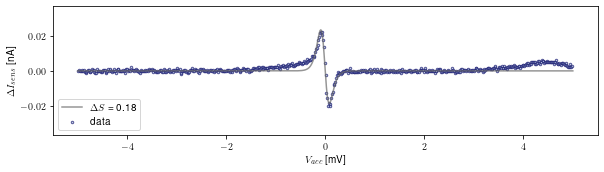

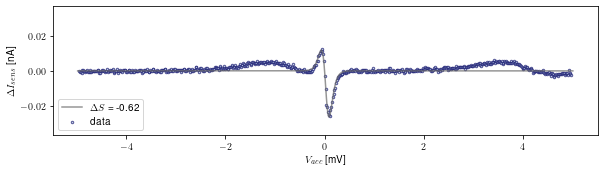

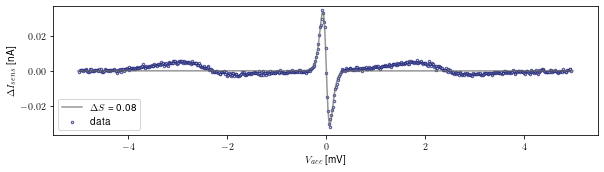

In [74]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

for i in [0,1,2]:
    enty = out[i].average_entropy_signal
    entx = out[i].x
    fitent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).eval_fit(entx)
    ent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.dS
    plt.scatter(entx/100, enty, marker="o", alpha=0.7, s=6, c='lightsteelblue', edgecolors="midnightblue", label='data')
    plt.plot(entx/100, fitent, c='dimgrey', alpha=0.7, label=r'$\Delta S$ = ' + f'{ent:.2f}')
    plt.ylabel(r'$\Delta I_{sens}$' + ' [nA]')
    plt.xlabel(r'$V_{acc}$ [mV]')
    plt.legend(loc='lower left')
    plt.yticks([-0.02, 0, 0.02])
    plt.ylim((-0.037,0.037))
    fig = plt.gcf()
    fig.set_size_inches(8.5, 2.5)
    plt.tight_layout()
    fig.savefig(f'Exports/thesis/{dats[i].datnum}.pdf', format='pdf')
    plt.show()

    
#     fig.add_trace(go.Scatter(mode='markers', 
#                              x=entx,
#                              y=enty,
#                              name= f'dat{dats[i].datnum}, IP/2200:{dats[i].Logs.fds["IP1/200"]}'))
    
#     fig.add_trace(go.Scatter(mode='lines', x=entx, y=fitent, name=f'{datnums[i]}f, {ent}', marker_color='grey'))
# fig.update_layout(xaxis_title='ACC/100 /mV', yaxis_title='Entropy /kb',
#                       title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
# fig.show(renderer='browser')

In [1450]:
occ_data = get_dat(3064)
data = occ_data.Data.get_data('Experiment Copy/cscurrent_2d')
x=occ_data.Data.get_data('Experiment Copy/x_array')
y=occ_data.Data.get_data('Experiment Copy/y_array')
accs = [dat.Logs.fds["ACC*100"] for dat in dats]

In [1452]:
fig = go.Figure()
fig.add_trace(go.Heatmap(
                    z=np.diff(data), x=x[:-1], y=y))
fig.add_trace(go.Scatter(mode='markers+lines', 
                         x=ips, y=accs, 
                         text=[dat.datnum for dat in dats],
                         marker_color="White"))
fig.show(renderer='browser')

In [1545]:
dats[-1].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values

const=0
dS=0.25797
dT=0.051717
mid=-0.61138
theta=4.4479